In [173]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math, random

import seaborn as sns

import rdkit
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import MACCSkeys
from rdkit.Chem import rdMHFPFingerprint

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from scipy.stats import gaussian_kde

import os
import shutil
import sys
from argparse import ArgumentParser, Namespace
from multiprocessing import Pool
from typing import List, Tuple

from tqdm import tqdm

from grover.util.utils import get_data, makedirs, load_features, save_features
from grover.data.molfeaturegenerator import get_available_features_generators, \
    get_features_generator
from grover.data.task_labels import rdkit_functional_group_label_features_generator

In [174]:
#name must be dataset name for plotting display name
bbbp = pd.read_csv('data/bbbp_500.csv')
bace = pd.read_csv('data/bace_500.csv')
clintox = pd.read_csv('data/clintox_500.csv')
tox21 = pd.read_csv('data/tox21_500.csv')
toxcast = pd.read_csv('data/toxcast_500.csv')
sider = pd.read_csv('data/sider_500.csv')
qm7 = pd.read_csv('data/qm7_500.csv')
qm8 = pd.read_csv('data/qm8_500.csv')
lipo = pd.read_csv('data/lipo_500.csv')
esol = pd.read_csv('data/esol_500.csv')
freesolv = pd.read_csv('data/freesolv_500.csv')
zinc = pd.read_csv('data/zinc_500.csv')
chembl = pd.read_csv('data/chembl_500.csv')

In [175]:
bbbp_npz = np.load('model/embvec/bbbp_500.npz')
bace_npz = np.load('model/embvec/bace_500.npz')
clintox_npz = np.load('model/embvec/clintox_500.npz')
tox21_npz = np.load('model/embvec/tox21_500.npz')
toxcast_npz = np.load('model/embvec/toxcast_500.npz')
sider_npz = np.load('model/embvec/sider_500.npz')
zinc_npz = np.load('model/embvec/zinc_500.npz')
chembl_npz = np.load('model/embvec/chembl_500.npz')

In [176]:
pca = PCA(n_components=2, random_state=138)
tsne = TSNE(n_components=2, random_state=138)
scaler = StandardScaler()

# make df functions

In [221]:
def maccs_df(data, method, name):
    #make fingerprint
    fingerprints = []
    for i in range(len(data)):
        mol = Chem.MolFromSmiles(data.iloc[i,0])
        fingerprints.append(MACCSkeys.GenMACCSKeys(mol))
    
    #make object to string
    fingerprint_array = [list(fp.ToBitString()) for fp in fingerprints]
    fingerprint_array = np.array(fingerprint_array)
    
    #make pca_dataset
    method_data = method.fit_transform(fingerprint_array)
    
    kmeans = KMeans(n_clusters=2, random_state=138)
    clusters = kmeans.fit_predict(method_data)
    
    #make dataframe
    df = pd.DataFrame(method_data,columns=['dim1', 'dim2'])
    df['dataset']=name
    df['cluster']=clusters
    try : 
        df['label']=data.iloc[:,1]
    except : df['label']=0
    
    return df

In [240]:
mol = Chem.MolFromSmiles(bbbp.iloc[i,0])
len(MACCSkeys.GenMACCSKeys(mol).ToBitString())

167

In [222]:
def morgan_df(data, method, name):
    #make fingerprint
    fingerprints = []
    for i in range(len(data)):
        mol = Chem.MolFromSmiles(data.iloc[i,0])
        fingerprints.append(AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=1024))
    
    #make object to string
    fingerprint_array = [list(np.frombuffer(fp.ToBitString().encode(), 'u1') - ord('0')) for fp in fingerprints]
    
    #make pca_dataset
    method_data = method.fit_transform(fingerprint_array)
    
    kmeans = KMeans(n_clusters=2, random_state=138)
    clusters = kmeans.fit_predict(method_data)
    
    #make dataframe
    df = pd.DataFrame(method_data,columns=['dim1', 'dim2'])
    df['dataset']=name
    df['cluster']=clusters
    try : 
        df['label']=data.iloc[:,1]
    except : df['label']=0
    
    return df

In [223]:
def grover_df(data, features, method, name):
    method_data = method.fit_transform(features['fps'])
    
    kmeans = KMeans(n_clusters=2, random_state=138)
    clusters = kmeans.fit_predict(method_data)
    
    df = pd.DataFrame(method_data,columns=['dim1', 'dim2'])
    df['dataset']=name
    df['cluster']=clusters
    try : 
        df['label']=data.iloc[:,1]
    except : df['label']=0
    return df

## grover_pca

In [88]:
bbbp_gpca = grover_df(bbbp, bbbp_npz, pca, 'bbbp')
bace_gpca = grover_df(bace, bace_npz, pca, 'bace')
clintox_gpca = grover_df(clintox, clintox_npz, pca, 'clintox')
sider_gpca = grover_df(sider, sider_npz, pca, 'sider')
tox21_gpca = grover_df(tox21, tox21_npz, pca, 'tox21')
toxcast_gpca = grover_df(toxcast, toxcast_npz, pca, 'toxcast')
zinc_gpca = grover_df(zinc, zinc_npz, pca, 'zinc')
chembl_gpca = grover_df(chembl, chembl_npz, pca, 'chembl')

In [89]:
grover_pca_df = pd.concat([bbbp_gpca, bace_gpca, clintox_gpca, tox21_gpca, toxcast_gpca, sider_gpca, zinc_gpca, chembl_gpca])
grover_pca_df['cluster'] = grover_pca_df['cluster'].astype('category')

In [345]:
sns.set_style('white')

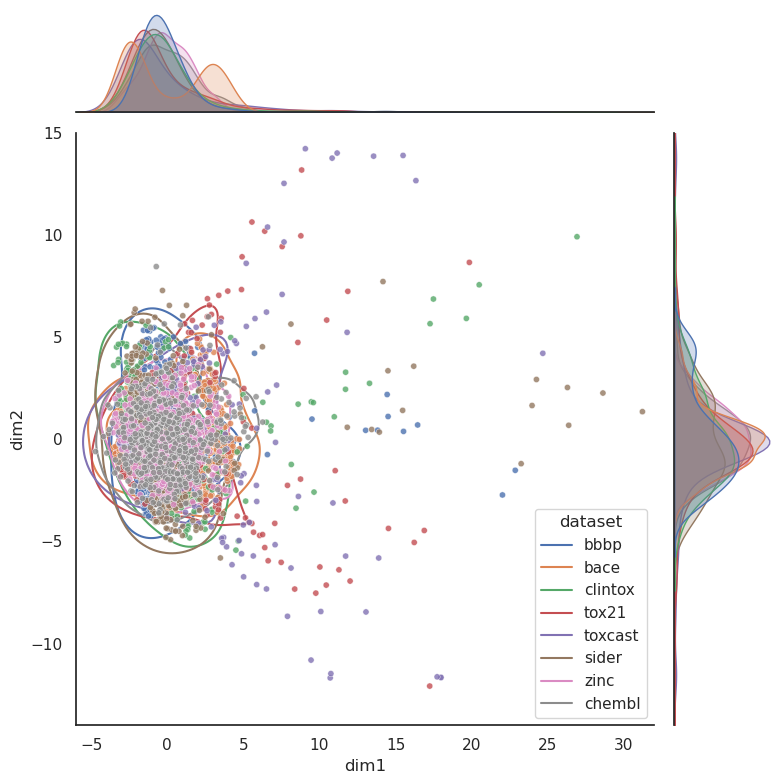

In [366]:
g = sns.jointplot(data=grover_pca_df,
    x="dim1", y="dim2", hue='dataset',
    kind="scatter", s=20, alpha=0.8, height=8, xlim=[-6, 32], ylim=[-14, 15]
)
g.plot_joint(sns.kdeplot, color="r", zorder=0, levels=3)
plt.show()

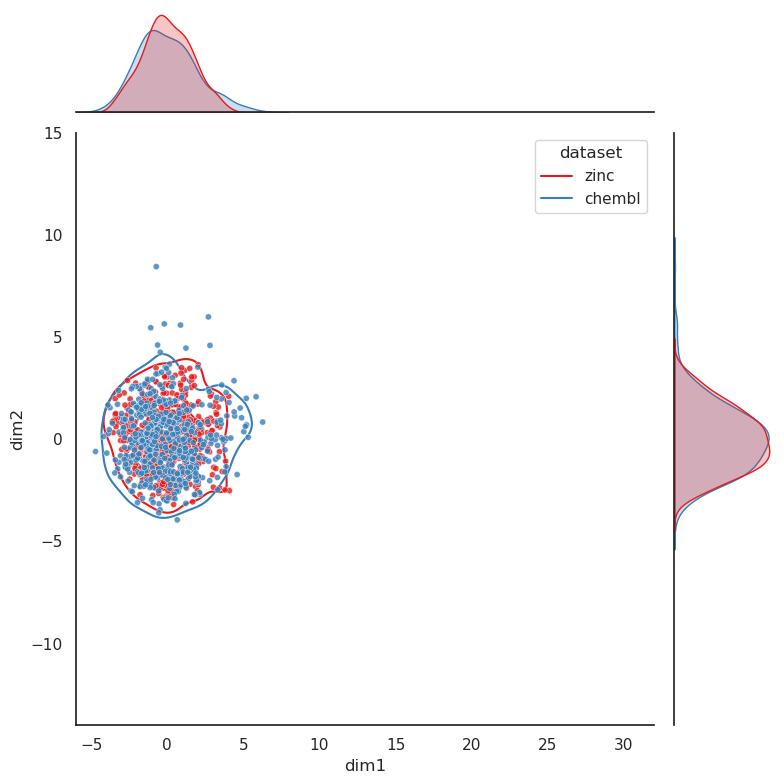

In [358]:
g = sns.jointplot(data=pd.concat([zinc_gpca, chembl_gpca]),
    x="dim1", y="dim2", hue='dataset',palette='Set1', 
    kind="scatter", s=20, alpha=0.8, height=8, xlim=[-6, 32], ylim=[-14, 15]
)
g.plot_joint(sns.kdeplot, color="r", zorder=0, levels=3)
plt.show()

				bace_transformer_pca


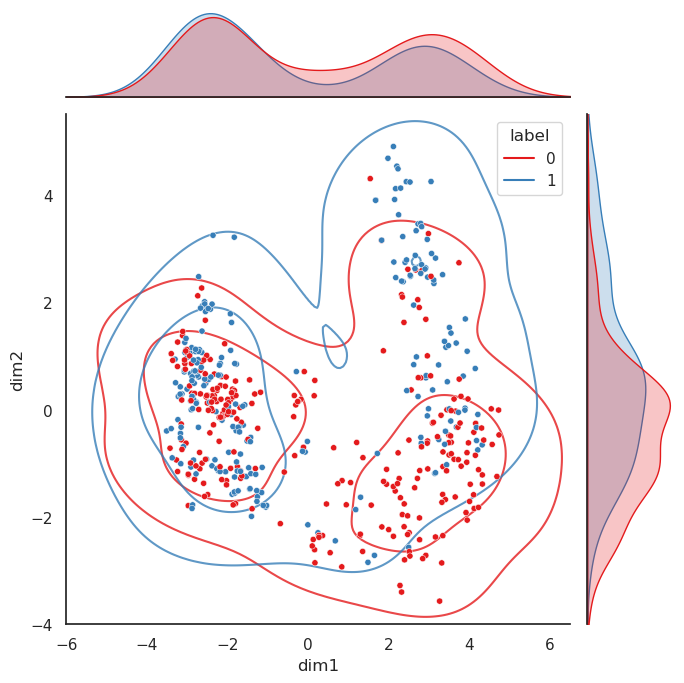

In [355]:
print('\t\t\t\tbace_transformer_pca')
g = sns.jointplot(data=bace_gpca,
    x="dim1", y="dim2", hue='label', palette='Set1', 
    kind="scatter", s=20, alpha=1, height=7, xlim=[-6, 6.5], ylim=[-4, 5.5]
)
g.plot_joint(sns.kdeplot, zorder=0, levels=3, alpha=0.8)
plt.show()

				bbbp_transformer_pca


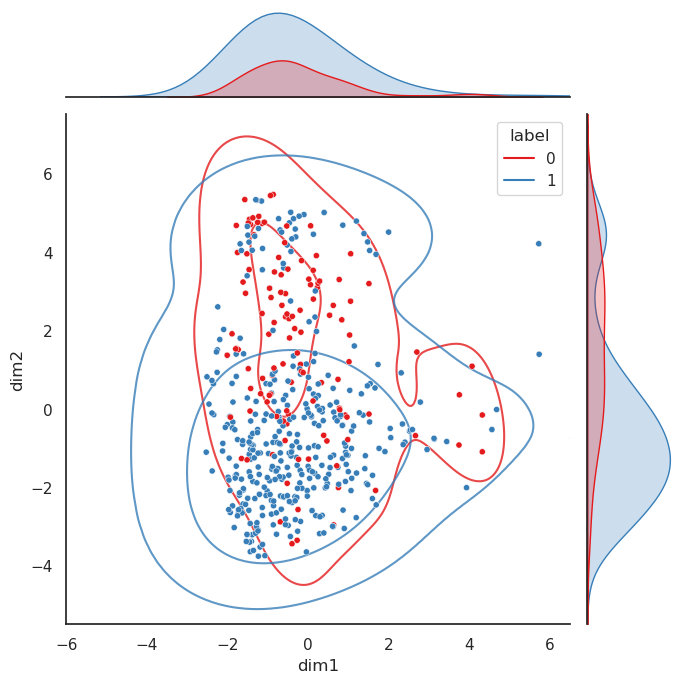

In [419]:
print('\t\t\t\tbbbp_transformer_pca')
g = sns.jointplot(data=bbbp_gpca,
    x="dim1", y="dim2", hue='label', palette='Set1', 
    kind="scatter", s=20, alpha=1, height=7, xlim=[-6, 6.5], ylim=[-5.5, 7.5]
)
g.plot_joint(sns.kdeplot, zorder=0, levels=3, alpha=0.8)
plt.show()

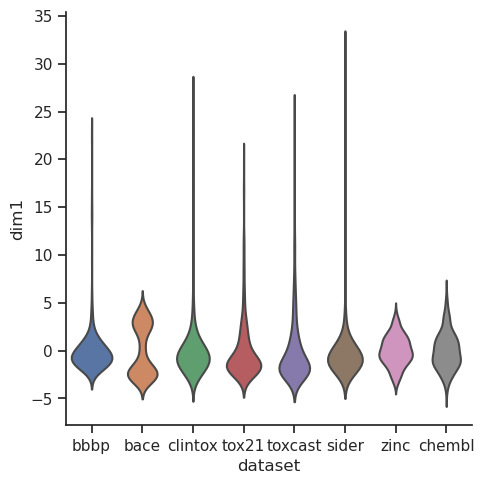

In [144]:
g = sns.catplot(data=grover_pca_df, x="dataset", y="dim1", kind="violin", inner=None)
#sns.swarmplot(data=tips, x="day", y="total_bill", color="k", size=3, ax=g.ax)
plt.show()

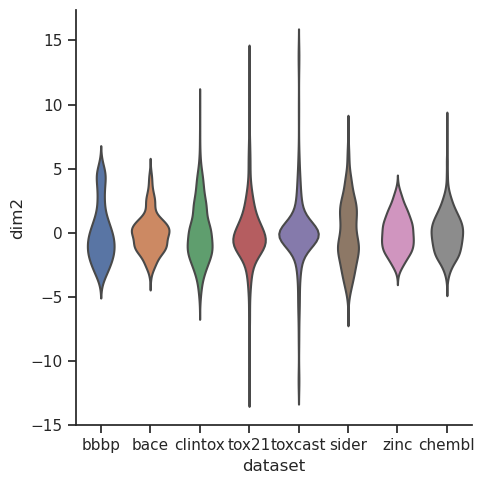

In [145]:
g = sns.catplot(data=grover_pca_df, x="dataset", y="dim2", kind="violin", inner=None)
#sns.swarmplot(data=tips, x="day", y="total_bill", color="k", size=3, ax=g.ax)
plt.show()

## grover_tsne

In [92]:
bbbp_gtsne = grover_df(bbbp, bbbp_npz, tsne, 'bbbp')
bace_gtsne = grover_df(bace, bace_npz, tsne, 'bace')
clintox_gtsne = grover_df(clintox, clintox_npz, tsne, 'clintox')
sider_gtsne = grover_df(sider, sider_npz, tsne, 'sider')
tox21_gtsne = grover_df(tox21, tox21_npz, tsne, 'tox21')
toxcast_gtsne = grover_df(toxcast, toxcast_npz, tsne, 'toxcast')
zinc_gtsne = grover_df(zinc, zinc_npz, tsne, 'zinc')
chembl_gtsne = grover_df(chembl, chembl_npz, tsne, 'chembl')

/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default lea

In [110]:
grover_tsne_df.head()

dim1       dim2 dataset cluster  label
0   9.449211   0.026952    bbbp       0    0.0
1  28.876690  -2.444650    bbbp       0    0.0
2   1.886365 -20.756672    bbbp       0    1.0
3  22.156849 -14.057807    bbbp       0    0.0
4  17.678944 -17.538570    bbbp       0    1.0

In [93]:
grover_tsne_df = pd.concat([bbbp_gtsne, bace_gtsne, clintox_gtsne, tox21_gtsne, toxcast_gtsne, sider_gtsne, zinc_gtsne, chembl_gtsne])
grover_tsne_df['cluster'] = grover_tsne_df['cluster'].astype('category')

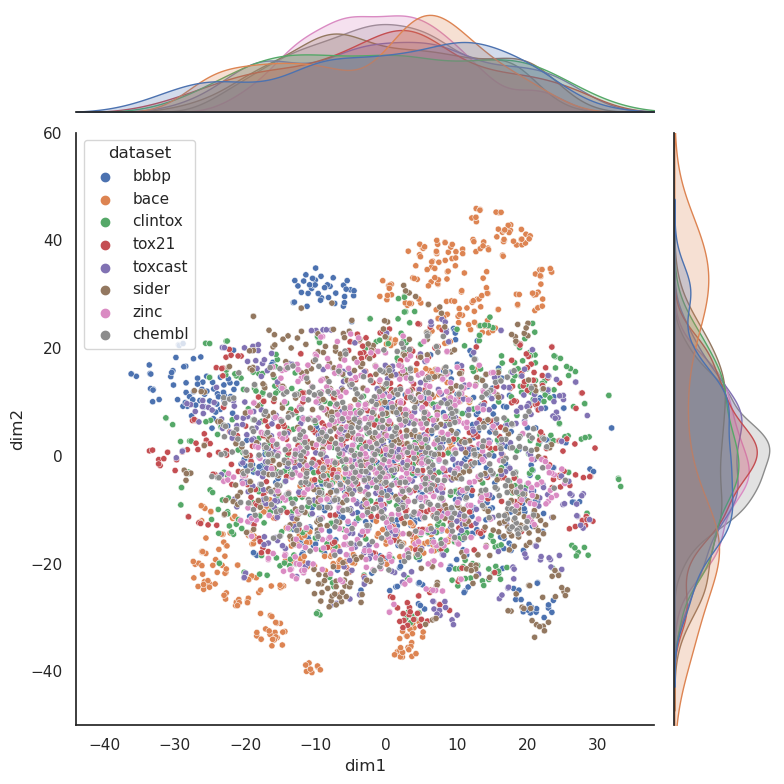

In [439]:
g = sns.jointplot(data=grover_tsne_df,
    x="dim1", y="dim2", hue='dataset',
    kind="scatter", s=20, alpha=1, height=8, xlim=[-44,38], ylim=[-50,60]
)
#g.plot_joint(sns.kdeplot, color="r", zorder=0, levels=3)
plt.show()

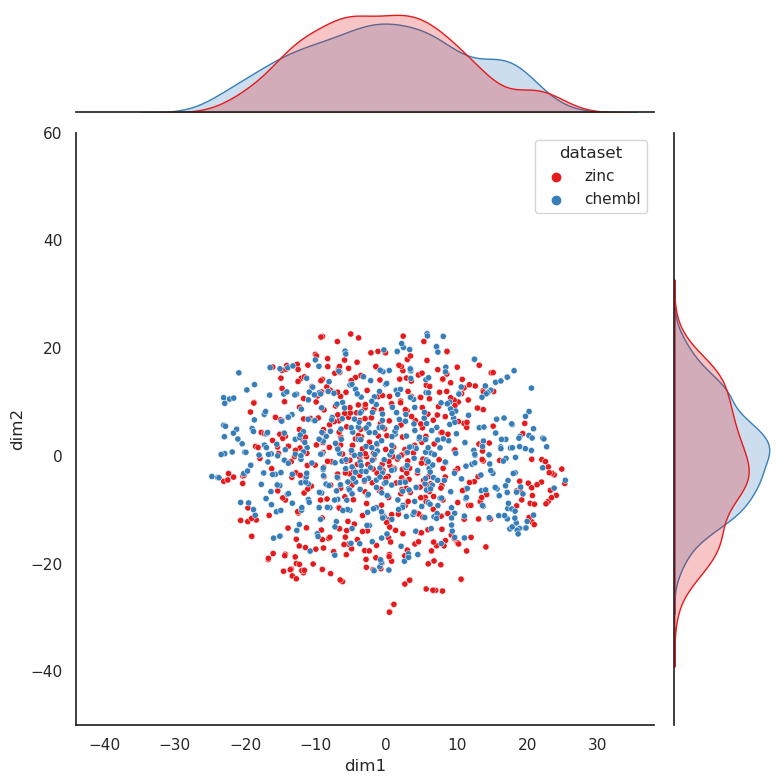

In [ ]:
g = sns.jointplot(data=pd.concat([zinc_gtsne,chembl_gtsne]),
    x="dim1", y="dim2", hue='dataset',palette='Set1', 
    kind="scatter", s=20, alpha=0.8, height=8, xlim=[-44,38], ylim=[-50,60]
)
g.plot_joint(sns.kdeplot, color="r", zorder=0, levels=3)
plt.show()

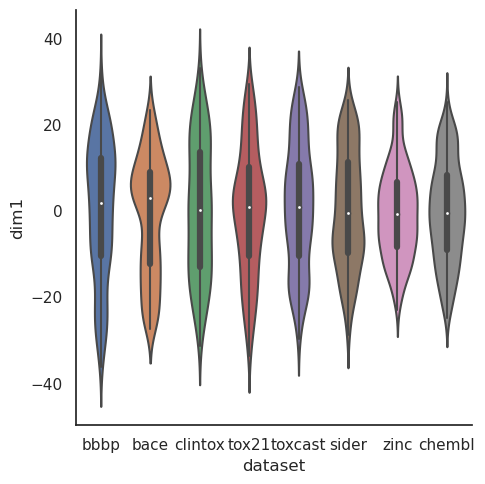

In [432]:
g = sns.catplot(data=grover_tsne_df, x="dataset", y="dim1", kind="violin")
#sns.swarmplot(data=tips, x="day", y="total_bill", color="k", size=3, ax=g.ax)
plt.show()

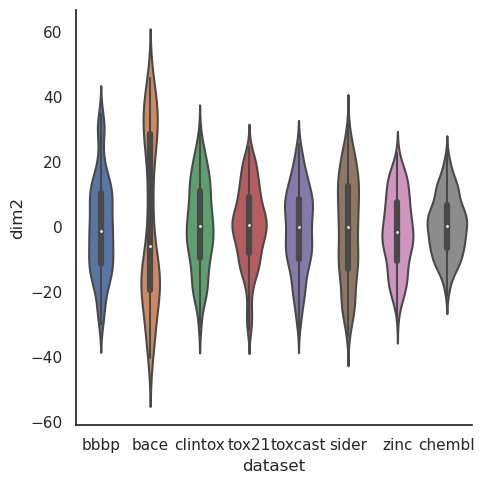

In [433]:
g = sns.catplot(data=grover_tsne_df, x="dataset", y="dim2", kind="violin")
#sns.swarmplot(data=tips, x="day", y="total_bill", color="k", size=3, ax=g.ax)
plt.show()

				bace_transformer_tsne


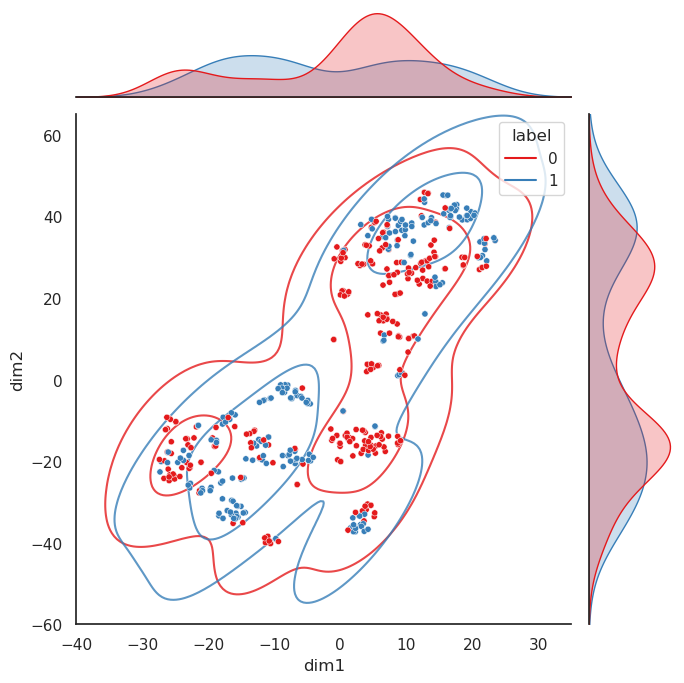

In [418]:
print('\t\t\t\tbace_transformer_tsne')
g = sns.jointplot(data=bace_gtsne,
    x="dim1", y="dim2", hue='label', palette='Set1', 
    kind="scatter", s=20, alpha=1, height=7, xlim=[-40, 35], ylim=[-60, 65]
)
g.plot_joint(sns.kdeplot, zorder=0, levels=3, alpha=0.8)
plt.show()

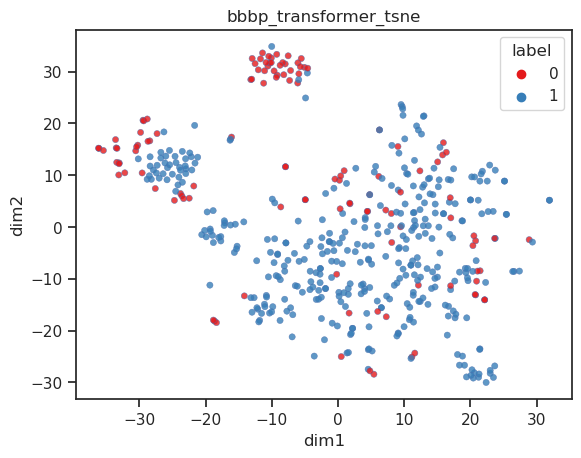

In [260]:
sns.scatterplot(data=bbbp_gtsne, x='dim1', y='dim2', hue='label', palette='Set1', s=20, alpha=0.8, edgecolor='b')
plt.title('bbbp_transformer_tsne')
plt.show()

# MACCS

## maccs_pca

In [157]:
bbbp_mpca = maccs_df(bbbp, pca, 'bbbp')
bace_mpca = maccs_df(bace, pca, 'bace')
clintox_mpca = maccs_df(clintox, pca, 'clintox')
sider_mpca = maccs_df(sider, pca, 'sider')
tox21_mpca = maccs_df(tox21, pca, 'tox21')
toxcast_mpca = maccs_df(toxcast, pca, 'toxcast')
zinc_mpca = maccs_df(zinc, pca, 'zinc')
chembl_mpca = maccs_df(chembl, pca, 'chembl')
maccs_pca_df = pd.concat([bbbp_mpca, bace_mpca, clintox_mpca, tox21_mpca, toxcast_mpca, sider_mpca, zinc_mpca, chembl_mpca])
maccs_pca_df['cluster'] = maccs_pca_df['cluster'].astype('category')

[14:19:20] WARNING: not removing hydrogen atom without neighbors
[14:19:20] WARNING: not removing hydrogen atom without neighbors
[14:19:20] WARNING: not removing hydrogen atom without neighbors
[14:19:20] WARNING: not removing hydrogen atom without neighbors
[14:19:20] WARNING: not removing hydrogen atom without neighbors
[14:19:20] WARNING: not removing hydrogen atom without neighbors
[14:19:20] WARNING: not removing hydrogen atom without neighbors
[14:19:21] WARNING: not removing hydrogen atom without neighbors
[14:19:21] WARNING: not removing hydrogen atom without neighbors


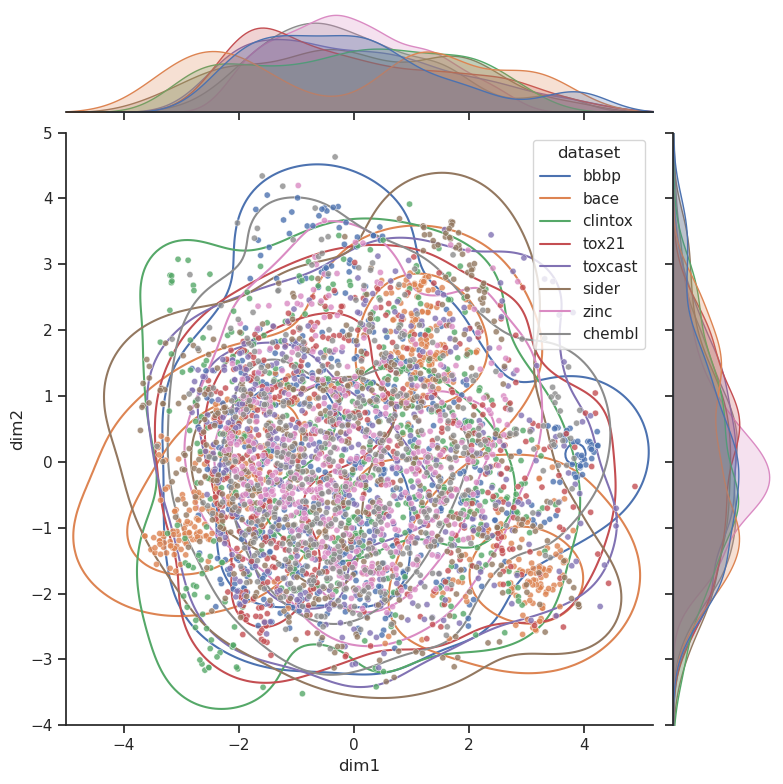

In [298]:
g = sns.jointplot(data=maccs_pca_df,
    x="dim1", y="dim2", hue='dataset',
    kind="scatter", s=20, alpha=0.8, height=8, xlim=[-5,5.2], ylim=[-4,5]
)
g.plot_joint(sns.kdeplot, color="r", zorder=0, levels=3)
plt.show()

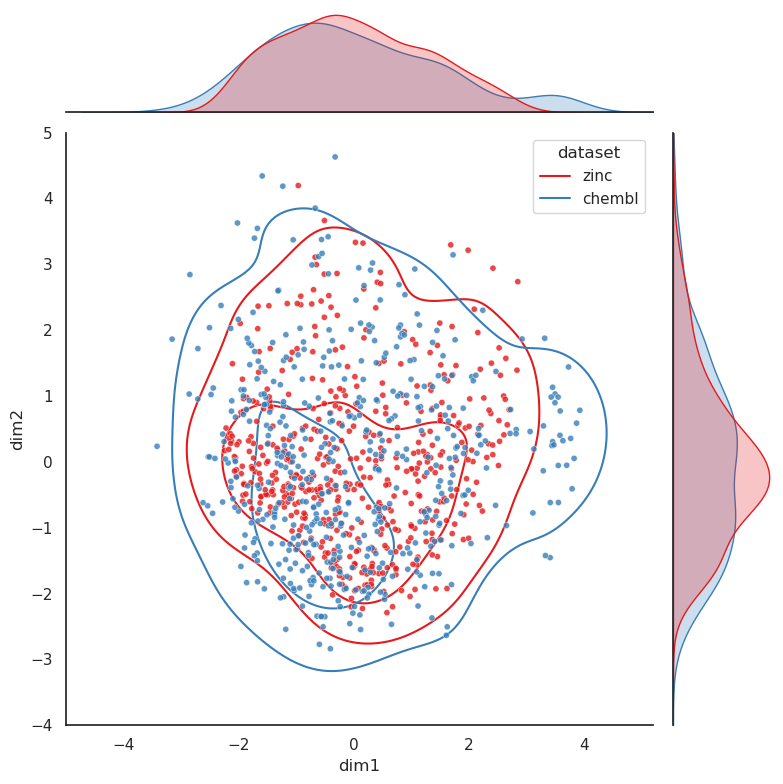

In [368]:
g = sns.jointplot(data=pd.concat([zinc_mpca, chembl_mpca]),
    x="dim1", y="dim2", hue='dataset',palette='Set1', 
    kind="scatter", s=20, alpha=0.8, height=8, xlim=[-5,5.2], ylim=[-4,5]
)
g.plot_joint(sns.kdeplot, color="r", zorder=0, levels=3)
plt.show()

				bace_maccs_pca


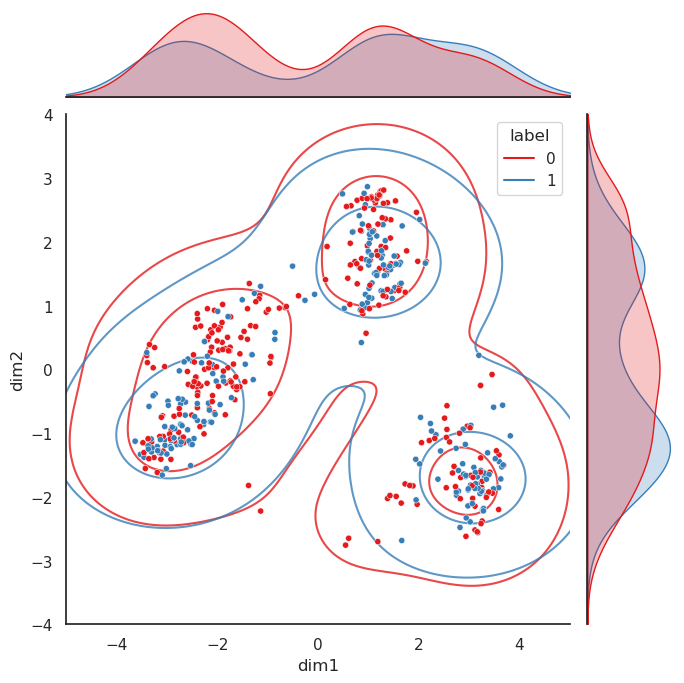

In [413]:
print('\t\t\t\tbace_maccs_pca')
g = sns.jointplot(data=bace_mpca,
    x="dim1", y="dim2", hue='label', palette='Set1', 
    kind="scatter", s=20, alpha=1, height=7, xlim=[-5, 5], ylim=[-4, 4]
)
g.plot_joint(sns.kdeplot, zorder=0, levels=3, alpha=0.8)
plt.show()

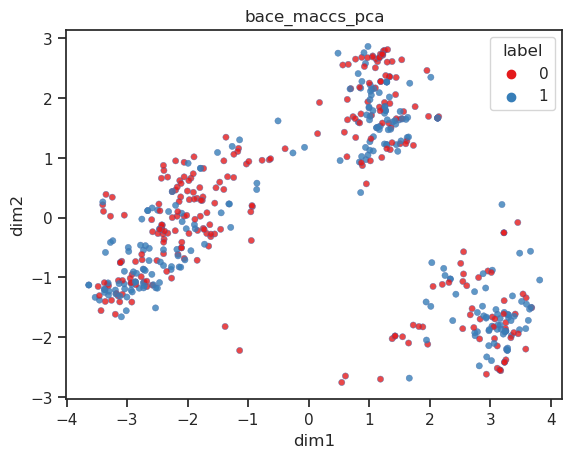

In [245]:
sns.scatterplot(data=bace_mpca, x='dim1', y='dim2', hue='label', palette='Set1', s=20, alpha=0.8, edgecolor='b')
plt.title('bace_maccs_pca')
plt.show()

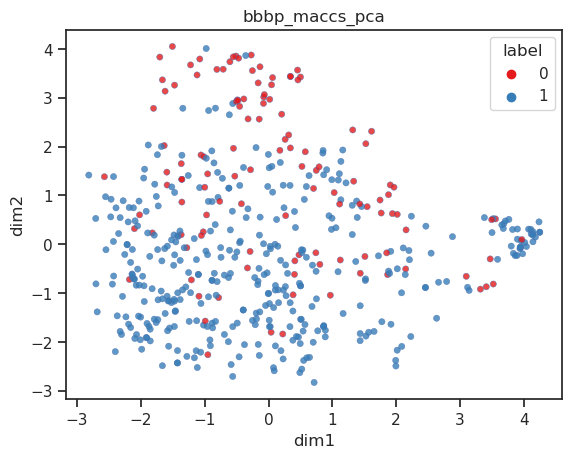

In [261]:
sns.scatterplot(data=bbbp_mpca, x='dim1', y='dim2', hue='label', palette='Set1', s=20, alpha=0.8, edgecolor='b')
plt.title('bbbp_maccs_pca')
plt.show()

## maccs_tsne

In [160]:
bbbp_mt = maccs_df(bbbp, tsne, 'bbbp')
bace_mt = maccs_df(bace, tsne, 'bace')
clintox_mt = maccs_df(clintox, tsne, 'clintox')
sider_mt = maccs_df(sider, tsne, 'sider')
tox21_mt = maccs_df(tox21, tsne, 'tox21')
toxcast_mt = maccs_df(toxcast, tsne, 'toxcast')
zinc_mt = maccs_df(zinc, tsne, 'zinc')
chembl_mt = maccs_df(chembl, tsne, 'chembl')
maccs_tsne_df = pd.concat([bbbp_mt, bace_mt, clintox_mt, tox21_mt, toxcast_mt, sider_mt, zinc_mt, chembl_mt])
maccs_tsne_df['cluster'] = maccs_pca_df['cluster'].astype('category')

[14:19:32] WARNING: not removing hydrogen atom without neighbors
[14:19:32] WARNING: not removing hydrogen atom without neighbors
[14:19:32] WARNING: not removing hydrogen atom without neighbors
[14:19:32] WARNING: not removing hydrogen atom without neighbors
[14:19:32] WARNING: not removing hydrogen atom without neighbors
[14:19:32] WARNING: not removing hydrogen atom without neighbors
[14:19:32] WARNING: not removing hydrogen atom without neighbors
/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/opt/

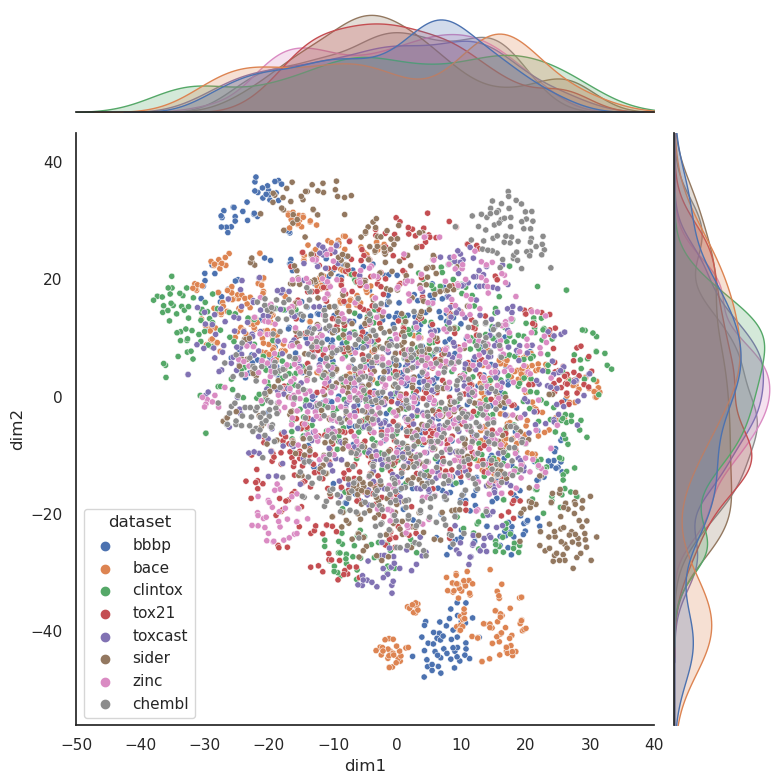

In [435]:
g = sns.jointplot(data=maccs_tsne_df,
    x="dim1", y="dim2", hue='dataset',
    kind="scatter", s=20, alpha=1, height=8, xlim=[-50,40], ylim=[-56,45]
)
#g.plot_joint(sns.kdeplot, color="r", zorder=0, levels=3)
plt.show()

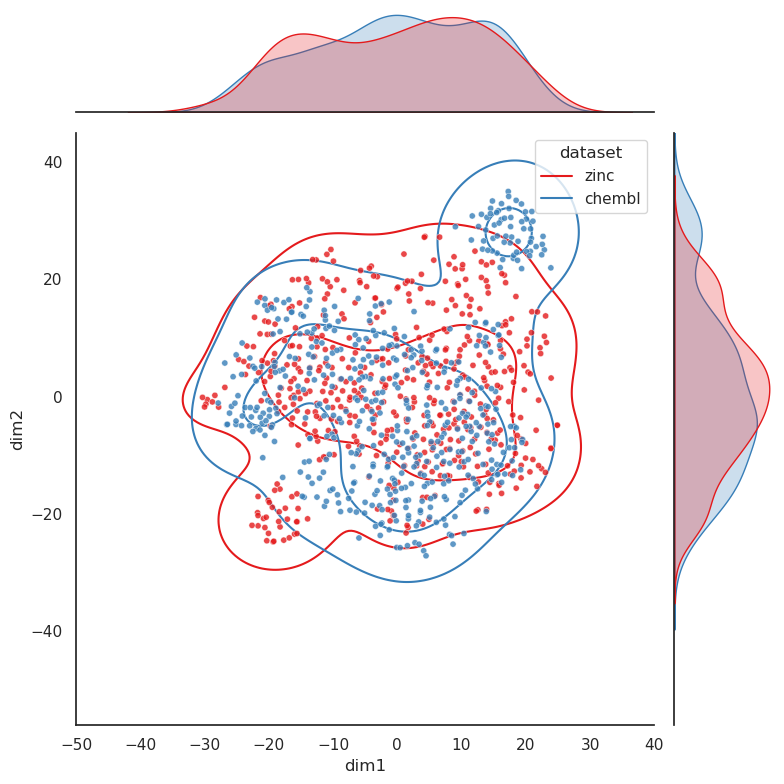

In [369]:
g = sns.jointplot(data=pd.concat([zinc_mt, chembl_mt]),
    x="dim1", y="dim2", hue='dataset',palette='Set1', 
    kind="scatter", s=20, alpha=0.8, height=8, xlim=[-50,40], ylim=[-56,45]
)
g.plot_joint(sns.kdeplot, color="r", zorder=0, levels=3)
plt.show()

				bace_maccs_tsne


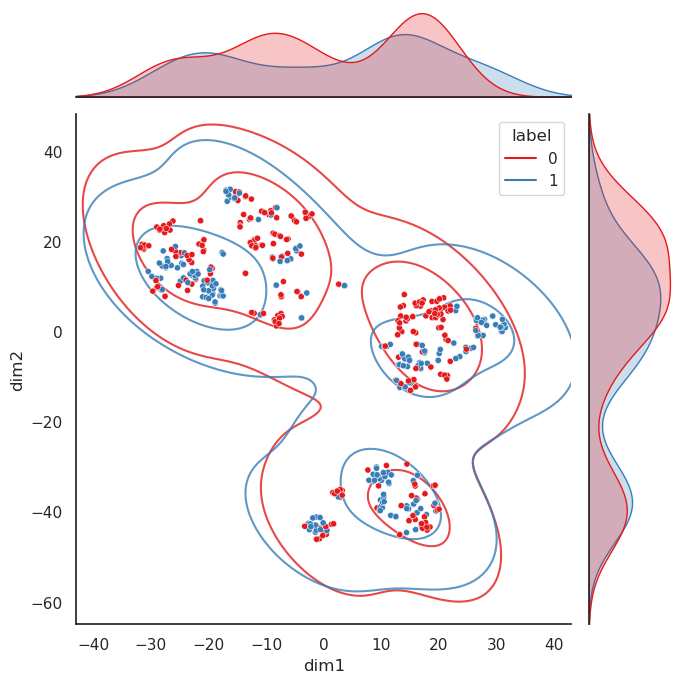

In [415]:
print('\t\t\t\tbace_maccs_tsne')
g = sns.jointplot(data=bace_mt,
    x="dim1", y="dim2", hue='label', palette='Set1', 
    kind="scatter", s=20, alpha=1, height=7, xlim=[-43, 43], ylim=[-65, 48]
)
g.plot_joint(sns.kdeplot, zorder=0, levels=3, alpha=0.8)
plt.show()

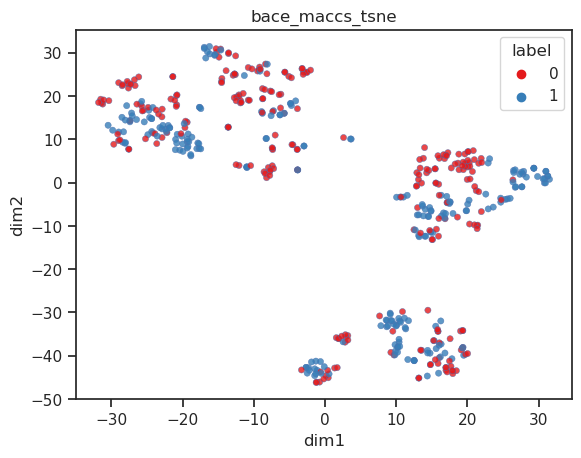

In [246]:
sns.scatterplot(data=bace_mt, x='dim1', y='dim2', hue='label', palette='Set1', s=20, alpha=0.8, edgecolor='b')
plt.title('bace_maccs_tsne')
plt.show()

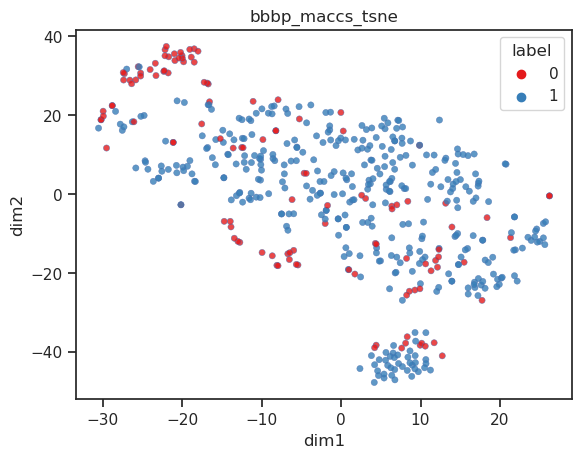

In [265]:
sns.scatterplot(data=bbbp_mt, x='dim1', y='dim2', hue='label', palette='Set1', s=20, alpha=0.8, edgecolor='b')
plt.title('bbbp_maccs_tsne')
plt.show()

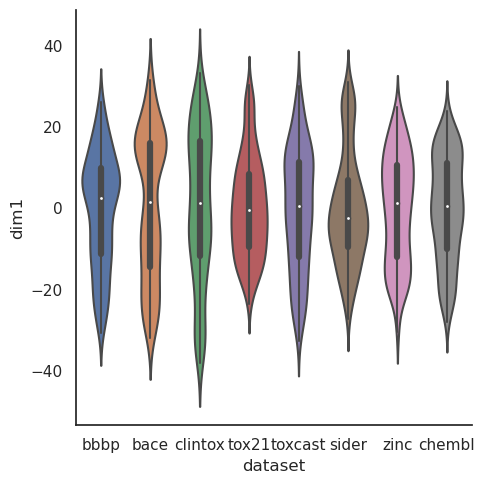

In [429]:
sns.catplot(data=maccs_tsne_df, x="dataset", y="dim1", kind="violin")
#sns.swarmplot(data=tips, x="day", y="total_bill", color="k", size=3, ax=g.ax)
plt.show()

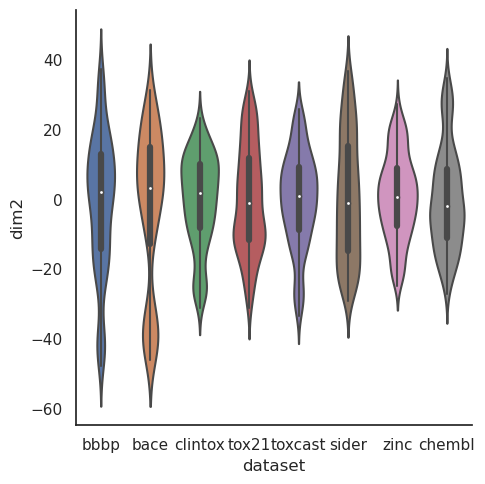

In [427]:
g = sns.catplot(data=maccs_tsne_df, x="dataset", y="dim2", kind="violin")
#sns.swarmplot(data=tips, x="day", y="total_bill", color="k", size=3, ax=g.ax)
plt.show()

# morgan

## morgan_pca

In [208]:
bbbp_mgpca = morgan_df(bbbp, pca, 'bbbp')
bace_mgpca = morgan_df(bace, pca, 'bace')
clintox_mgpca = morgan_df(clintox, pca, 'clintox')
sider_mgpca = morgan_df(sider, pca, 'sider')
tox21_mgpca = morgan_df(tox21, pca, 'tox21')
toxcast_mgpca = morgan_df(toxcast, pca, 'toxcast')
zinc_mgpca = morgan_df(zinc, pca, 'zinc')
chembl_mgpca = morgan_df(chembl, pca, 'chembl')
morgan_pca_df = pd.concat([bbbp_mgpca, bace_mgpca, clintox_mgpca, tox21_mgpca, toxcast_mgpca, sider_mgpca, zinc_mgpca, chembl_mgpca])
morgan_pca_df['cluster'] = morgan_pca_df['cluster'].astype('category')

[14:31:46] WARNING: not removing hydrogen atom without neighbors
[14:31:46] WARNING: not removing hydrogen atom without neighbors
[14:31:46] WARNING: not removing hydrogen atom without neighbors
[14:31:46] WARNING: not removing hydrogen atom without neighbors
[14:31:46] WARNING: not removing hydrogen atom without neighbors
[14:31:46] WARNING: not removing hydrogen atom without neighbors
[14:31:46] WARNING: not removing hydrogen atom without neighbors
[14:31:47] WARNING: not removing hydrogen atom without neighbors
[14:31:47] WARNING: not removing hydrogen atom without neighbors


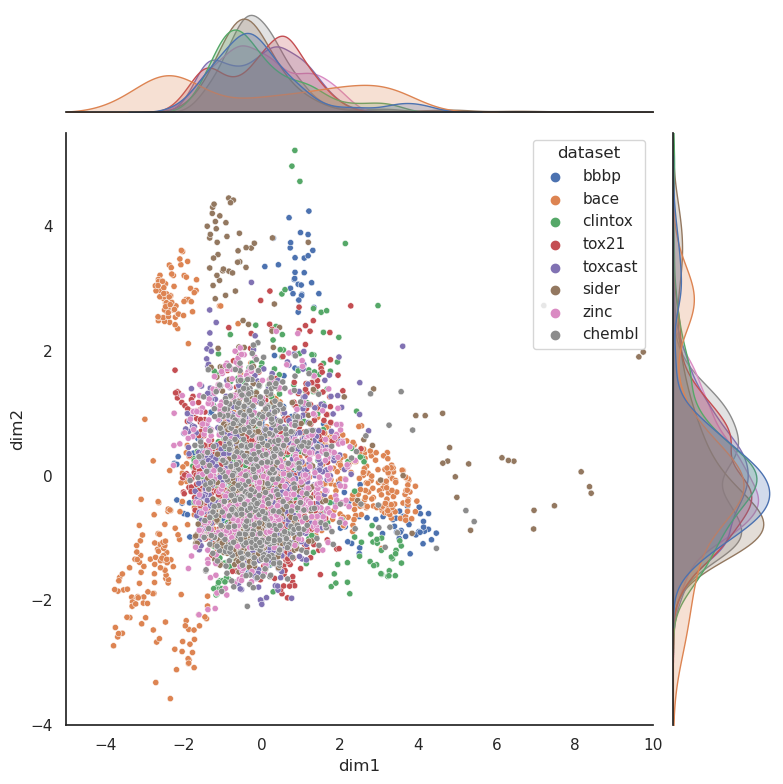

In [436]:
g = sns.jointplot(data=morgan_pca_df,
    x="dim1", y="dim2", hue='dataset',
    kind="scatter", s=20, alpha=1, height=8, xlim=[-5,10], ylim=[-4,5.5]
)
plt.show()

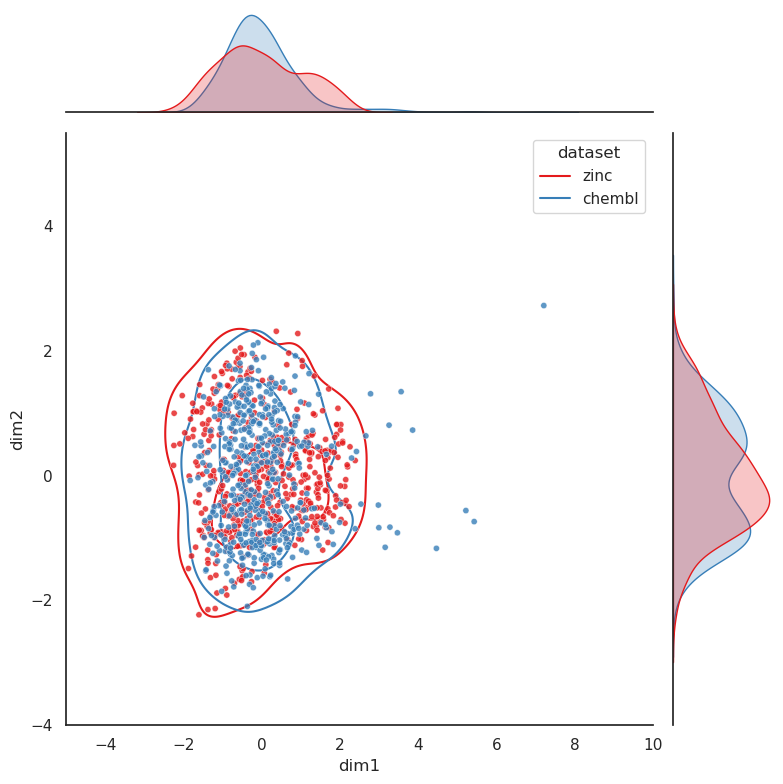

In [370]:
g = sns.jointplot(data=pd.concat([zinc_mgpca, chembl_mgpca]),
    x="dim1", y="dim2", hue='dataset',palette='Set1', 
    kind="scatter", s=20, alpha=0.8, height=8, xlim=[-5,10], ylim=[-4,5.5]
)
g.plot_joint(sns.kdeplot, color="r", zorder=0, levels=3)
plt.show()

				bace_morgan_pca


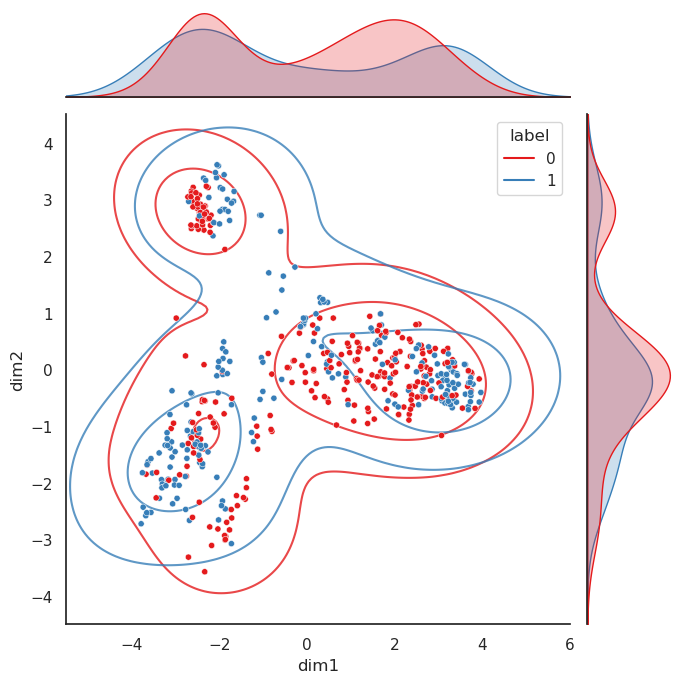

In [412]:
print('\t\t\t\tbace_morgan_pca')
g = sns.jointplot(data=bace_mgpca,
    x="dim1", y="dim2", hue='label', palette='Set1', 
    kind="scatter", s=20, alpha=1, height=7, xlim=[-5.5, 6], ylim=[-4.5, 4.5]
)
g.plot_joint(sns.kdeplot, zorder=0, levels=3, alpha=0.8)
plt.show()

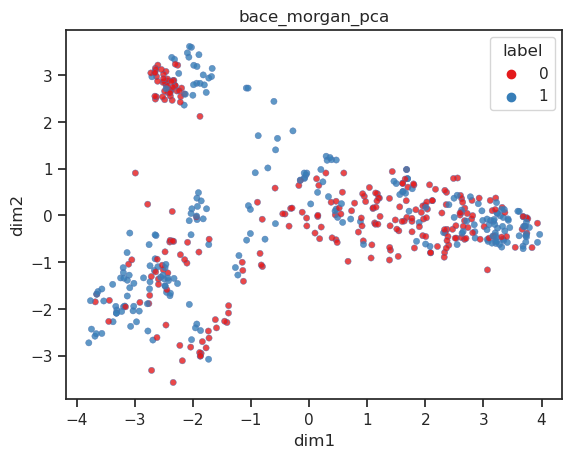

In [243]:
sns.scatterplot(data=bace_mgpca, x='dim1', y='dim2', hue='label', palette='Set1', s=20, alpha=0.8, edgecolor='b')
plt.title('bace_morgan_pca')
plt.show()

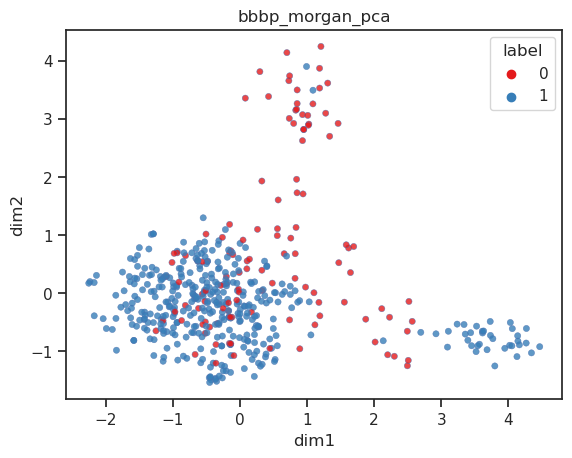

In [263]:
sns.scatterplot(data=bbbp_mgpca, x='dim1', y='dim2', hue='label', palette='Set1', s=20, alpha=0.8, edgecolor='b')
plt.title('bbbp_morgan_pca')
plt.show()

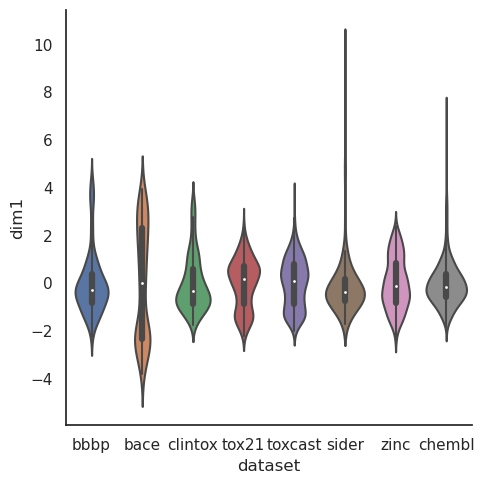

In [430]:
sns.catplot(data=morgan_pca_df, x="dataset", y="dim1", kind="violin")
#sns.swarmplot(data=tips, x="day", y="total_bill", color="k", size=3, ax=g.ax)
plt.show()

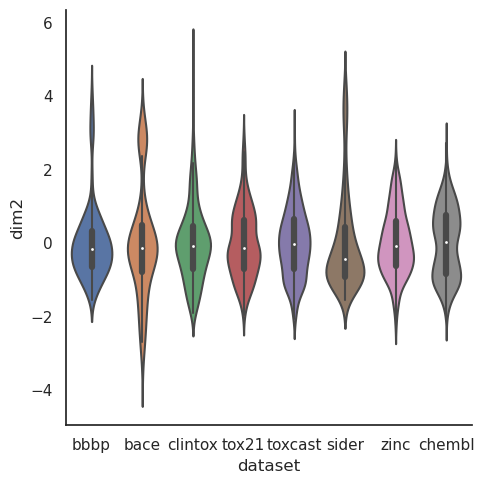

In [431]:
sns.catplot(data=morgan_pca_df, x="dataset", y="dim2", kind="violin")
#sns.swarmplot(data=tips, x="day", y="total_bill", color="k", size=3, ax=g.ax)
plt.show()

## morgan_tsne

In [213]:
bbbp_mgt = morgan_df(bbbp, tsne, 'bbbp')
bace_mgt = morgan_df(bace, tsne, 'bace')
clintox_mgt = morgan_df(clintox, tsne, 'clintox')
sider_mgt = morgan_df(sider, tsne, 'sider')
tox21_mgt = morgan_df(tox21, tsne, 'tox21')
toxcast_mgt = morgan_df(toxcast, tsne, 'toxcast')
zinc_mgt = morgan_df(zinc, tsne, 'zinc')
chembl_mgt = morgan_df(chembl, tsne, 'chembl')
morgan_tsne_df = pd.concat([bbbp_mgt, bace_mgt, clintox_mgt, tox21_mgt, toxcast_mgt, sider_mgt, zinc_mgt, chembl_mgt])
morgan_tsne_df['cluster'] = morgan_tsne_df['cluster'].astype('category')

[14:33:55] WARNING: not removing hydrogen atom without neighbors
[14:33:55] WARNING: not removing hydrogen atom without neighbors
[14:33:55] WARNING: not removing hydrogen atom without neighbors
[14:33:55] WARNING: not removing hydrogen atom without neighbors
[14:33:55] WARNING: not removing hydrogen atom without neighbors
[14:33:55] WARNING: not removing hydrogen atom without neighbors
[14:33:55] WARNING: not removing hydrogen atom without neighbors
/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/opt/

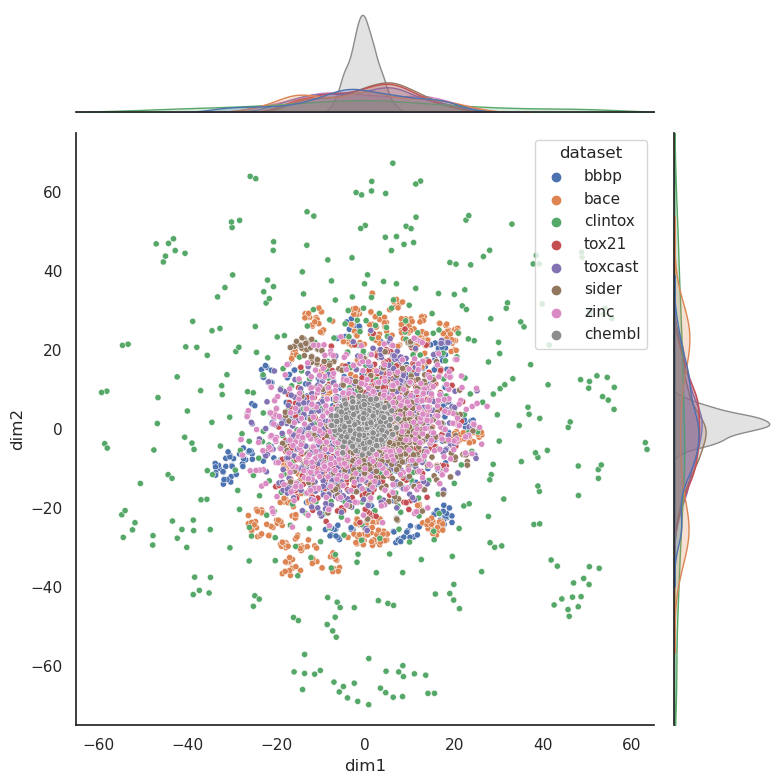

In [440]:
g = sns.jointplot(data=morgan_tsne_df,
    x="dim1", y="dim2", hue='dataset',
    kind="scatter", s=20, alpha=1, height=8, xlim=[-65,65], ylim=[-75,75]
)
#g.plot_joint(sns.kdeplot, color="r", zorder=0, levels=3)
plt.show()

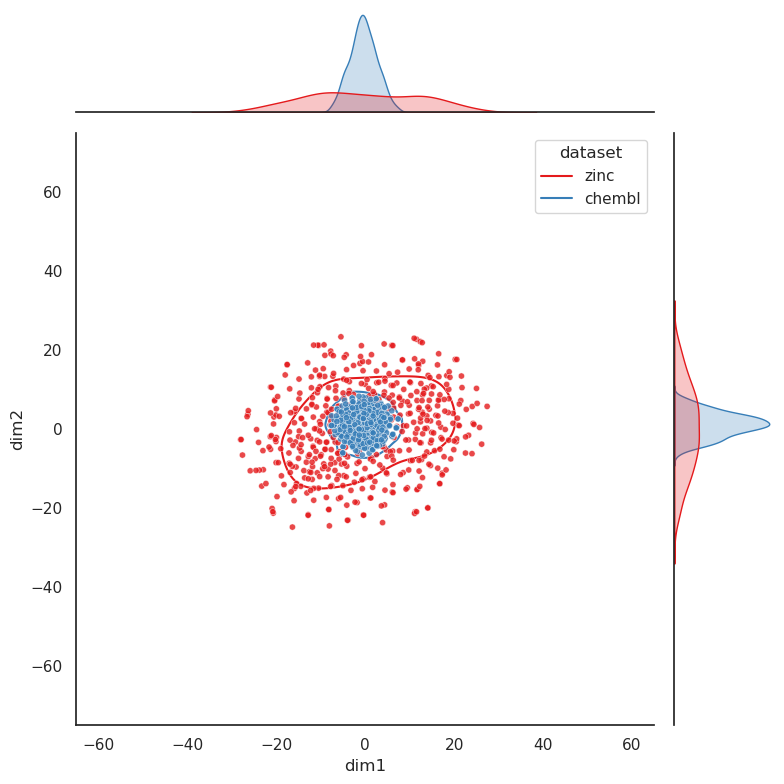

In [373]:
g = sns.jointplot(data=pd.concat([zinc_mgt, chembl_mgt]),
    x="dim1", y="dim2", hue='dataset', palette='Set1', 
    kind="scatter", s=20, alpha=0.8, height=8, xlim=[-65,65], ylim=[-75,75]
)
g.plot_joint(sns.kdeplot, color="r", zorder=0, levels=3)
plt.show()

				bace_morgan_tsne


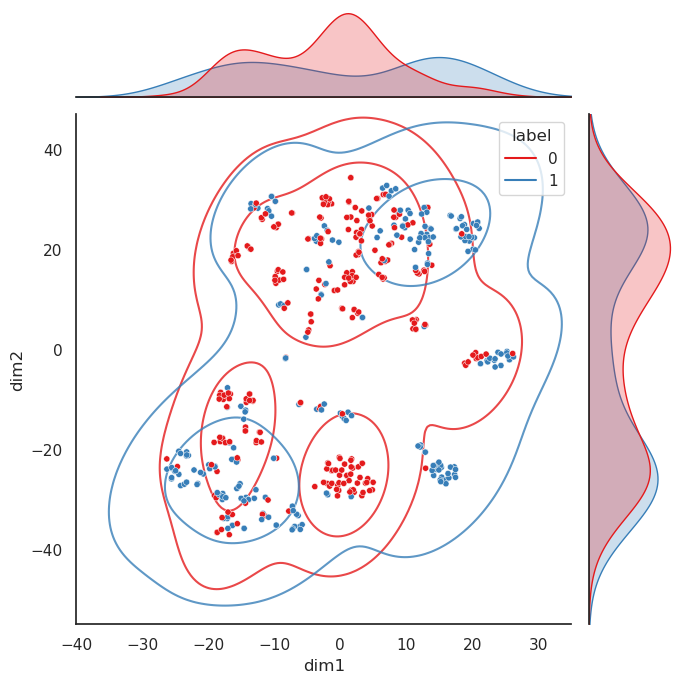

In [411]:
print('\t\t\t\tbace_morgan_tsne')
g = sns.jointplot(data=bace_mgt,
    x="dim1", y="dim2", hue='label', palette='Set1', 
    kind="scatter", s=20, alpha=1, height=7, xlim=[-40, 35], ylim=[-55, 47]
)
g.plot_joint(sns.kdeplot, zorder=0, levels=3, alpha=0.8)
plt.show()

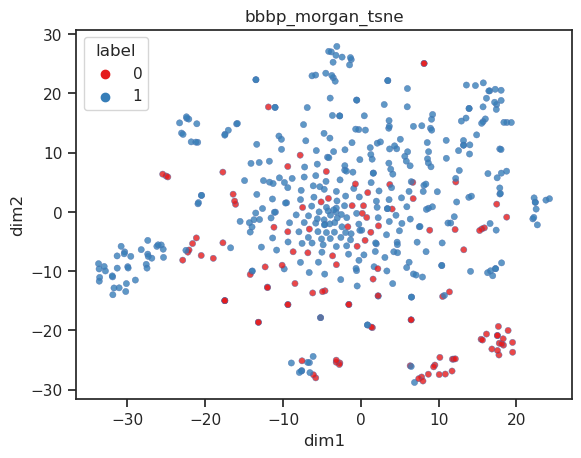

In [264]:
sns.scatterplot(data=bbbp_mgt, x='dim1', y='dim2', hue='label', palette='Set1', s=20, alpha=0.8, edgecolor='b')
plt.title('bbbp_morgan_tsne')
plt.show()

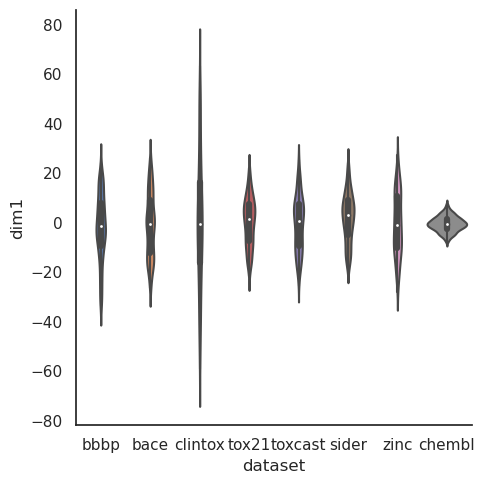

In [441]:
sns.catplot(data=morgan_tsne_df, x="dataset", y="dim1", kind="violin")
#sns.swarmplot(data=tips, x="day", y="total_bill", color="k", size=3, ax=g.ax)
plt.show()

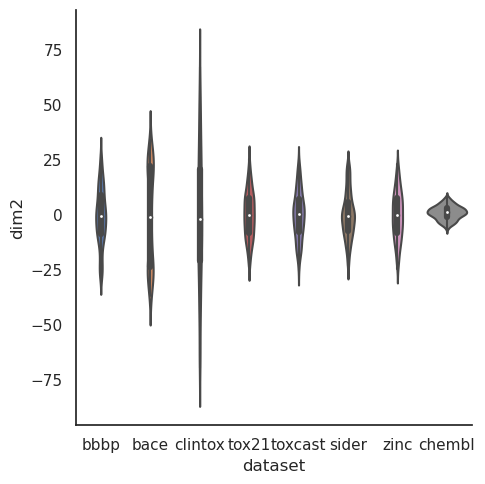

In [442]:
sns.catplot(data=morgan_tsne_df, x="dataset", y="dim2", kind="violin")
#sns.swarmplot(data=tips, x="day", y="total_bill", color="k", size=3, ax=g.ax)
plt.show()